# 1 Luồng xử lý của ảnh

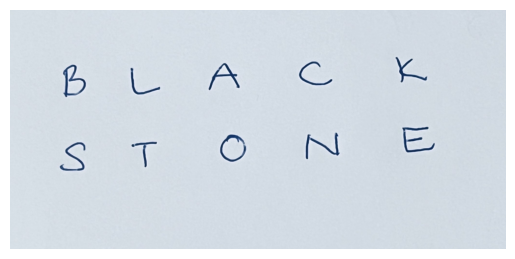

In [1]:
import cv2
import matplotlib.pyplot as plt

# Đọc ảnh mẫu
sample_img = cv2.imread("img\IMG-00.jpg") 
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB) 

plt.imshow(sample_img)
plt.axis('off')
plt.show()

## 1.1 Tiền xử lý ảnh

- Đọc ảnh màu từ đường dẫn (cv2.imread).
- Chuyển sang grayscale (cv2.cvtColor).
- Làm mờ ảnh để giảm nhiễu (cv2.GaussianBlur).
- Chuyển ảnh sang binary inverted (nền trắng, chữ đen) với Otsu thresholding.
- Dilation: phóng to các vùng chữ để liên kết nét đứt.
- Output: ảnh nhị phân (thresh) sẵn sàng để tách dòng/ ký tự.

### 1.1.1 Hàm dùng chung

In [2]:
import cv2
import numpy as np

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3,3), 0)
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
    thresh = cv2.dilate(thresh, kernel, iterations=1)
    return thresh

### 1.1.2 Mô phỏng với ảnh mẫu

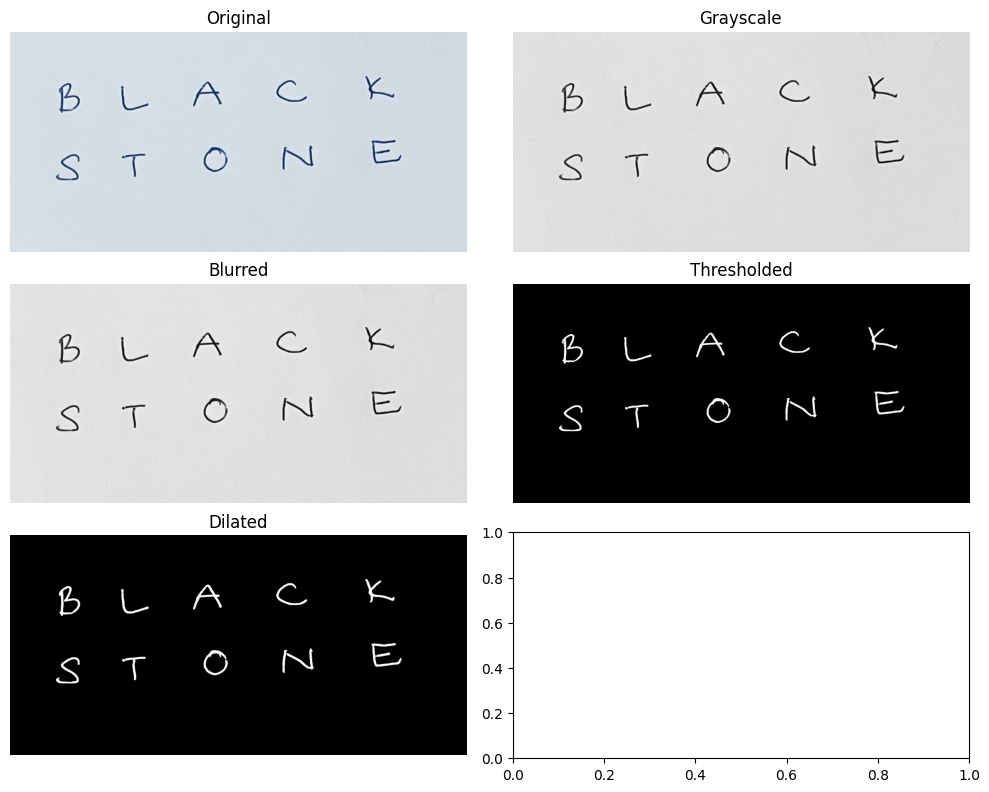

In [3]:
import cv2
import matplotlib.pyplot as plt

gray = cv2.cvtColor(sample_img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (3,3), 0)
_, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
dilated = cv2.dilate(thresh, kernel, iterations=1)

fig, axes = plt.subplots(3, 2, figsize=(10,8))
axes = axes.flatten()

axes[0].imshow(sample_img)
axes[0].set_title("Original")
axes[0].axis('off')

axes[1].imshow(gray, cmap='gray')
axes[1].set_title("Grayscale")
axes[1].axis('off')

axes[2].imshow(blur, cmap='gray')
axes[2].set_title("Blurred")
axes[2].axis('off')

axes[3].imshow(thresh, cmap='gray')
axes[3].set_title("Thresholded")
axes[3].axis('off')

axes[4].imshow(dilated, cmap='gray')
axes[4].set_title("Dilated")
axes[4].axis('off')

plt.tight_layout()
plt.show()


## 1.2 Tách dòng từ block

### 1.2.1 Hàm dùng chung

In [4]:
def split_lines(block, line_gap=5):
    horizontal_sum = np.sum(block, axis=1)
    in_line = False
    line_boxes = []
    for i, val in enumerate(horizontal_sum):
        if val > 0 and not in_line:
            in_line = True
            y0 = i
        elif val == 0 and in_line:
            in_line = False
            y1 = i
            if y1 - y0 > line_gap:
                line_boxes.append((y0, y1))
    if in_line:
        line_boxes.append((y0, block.shape[0]-1))
    return line_boxes

### 1.2.2 Mô phỏng với ảnh mẫu

[(198, 363), (484, 665)]


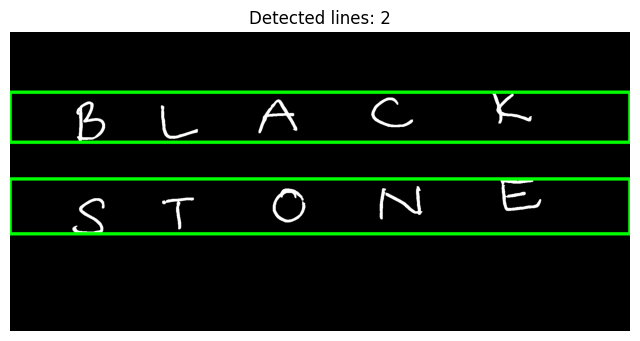

In [5]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

lines = split_lines(dilated, line_gap=5)
print(lines)

img_lines = cv2.cvtColor(dilated, cv2.COLOR_GRAY2BGR)
for y0, y1 in lines:
    cv2.rectangle(img_lines, (0, y0), (img_lines.shape[1]-1, y1), (0,255,0), 10)

plt.figure(figsize=(8,12))
plt.imshow(img_lines)
plt.title(f"Detected lines: {len(lines)}")
plt.axis('off')
plt.show()


## 1.3 Tách ký tự trong dòng

### 1.3.1 Hàm dùng chung

In [6]:
def split_characters(line_roi, min_gap=2):
    vertical_sum = np.sum(line_roi, axis=0)
    in_char = False
    char_boxes = []
    for i, val in enumerate(vertical_sum):
        if val > 0 and not in_char:
            in_char = True
            x0 = i
        elif val == 0 and in_char:
            in_char = False
            x1 = i
            if x1 - x0 > min_gap:
                char_boxes.append((x0, x1))
    if in_char:
        char_boxes.append((x0, line_roi.shape[1]-1))
    return char_boxes

### 1.3.2 Mô phỏng với ảnh mẫu

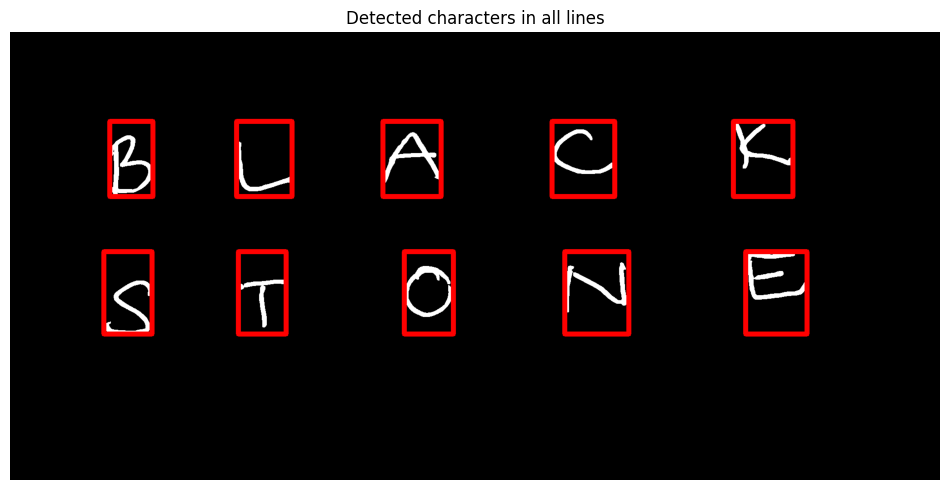

In [7]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

img_chars = cv2.cvtColor(dilated, cv2.COLOR_GRAY2BGR)
for y0, y1 in lines:
    line_roi = dilated[y0:y1, :]
    chars = split_characters(line_roi, min_gap=2)
    for x0, x1 in chars:
        cv2.rectangle(img_chars, (x0, y0), (x1, y1), (255,0,0), 10)

plt.figure(figsize=(12, 16))
plt.imshow(img_chars)
plt.title("Detected characters in all lines")
plt.axis('off')
plt.show()


## 1.4 Chuẩn hóa kí tự

### 1.4.1 Hàm dùng chung

In [8]:
def normalize_character(char_roi, target_size=(32,32)):
    rows = np.any(char_roi, axis=1)
    if not np.any(rows):
        return None
    y_start, y_end = np.where(rows)[0][[0,-1]]
    char_roi = char_roi[y_start:y_end+1, :]
    
    h, w = char_roi.shape
    max_side = max(h,w)
    if max_side == 0:
        return None
    scale = (target_size[0]-4)/max_side
    new_w, new_h = max(1,int(w*scale)), max(1,int(h*scale))
    char_resized = cv2.resize(char_roi, (new_w,new_h), interpolation=cv2.INTER_AREA)
    
    pad_top = (target_size[0]-new_h)//2
    pad_bottom = target_size[0]-new_h-pad_top
    pad_left = (target_size[1]-new_w)//2
    pad_right = target_size[1]-new_w-pad_left
    char_padded = np.pad(char_resized, ((pad_top,pad_bottom),(pad_left,pad_right)),
                         mode='constant', constant_values=0)
    return char_padded

### 1.4.2 Mô phỏng với ảnh mẫu

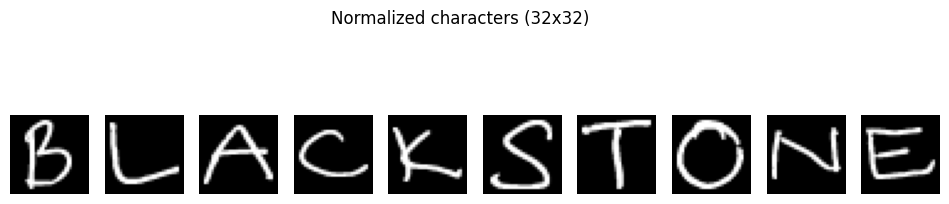

In [9]:
# Lưu các ký tự đã chuẩn hóa vào danh sách
normalized_chars = []

for y0, y1 in lines:
    line_roi = dilated[y0:y1, :]
    chars = split_characters(line_roi, min_gap=2)
    for x0, x1 in chars:
        char_roi = line_roi[:, x0:x1]
        char_norm = normalize_character(char_roi, target_size=(32,32))
        if char_norm is not None:
            normalized_chars.append(char_norm)

plt.figure(figsize=(12,3))
for i, char in enumerate(normalized_chars[:10]):
    plt.subplot(1, 10, i+1)
    plt.imshow(char, cmap='gray')
    plt.axis('off')
plt.suptitle("Normalized characters (32x32)")
plt.show()


## 1.5 Hàm gọi tổng hợp (từ 1.1 đến 1.4)

In [10]:
def extract_characters_from_image_handwriting(image_path, target_size=(32,32), min_gap=2, line_gap=5, block_height=1000):
    thresh = preprocess_image(image_path)
    chars = []
    height = thresh.shape[0]
    
    for start_row in range(0, height, block_height):
        end_row = min(start_row + block_height, height)
        block = thresh[start_row:end_row, :]
        lines = split_lines(block, line_gap)
        
        for y0, y1 in lines:
            line_roi = block[y0:y1, :]
            char_boxes = split_characters(line_roi, min_gap)
            
            for x0, x1 in char_boxes:
                char_roi = line_roi[:, x0:x1]
                char_norm = normalize_character(char_roi, target_size)
                if char_norm is not None:
                    chars.append(char_norm)
    
    return chars

# 2 Dự đoán kí tự

In [11]:
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model

def predict_characters(chars, model_path="model/best_emnist_cnn.keras", label_map_path="emnist_dataset/emnist-balanced-mapping.txt"):
    model = load_model(model_path)

    label_map = pd.read_csv(label_map_path, delimiter=' ', index_col=0, header=None).iloc[:,0]
    label_df = pd.DataFrame({'ascii': label_map, 'char': label_map.apply(chr)})
    
    processed_chars = []
    for c in chars:
        rotated = cv2.rotate(c, cv2.ROTATE_90_CLOCKWISE)
        flipped = cv2.flip(rotated, 1)
        processed_chars.append(flipped)
    
    X = np.array(processed_chars, dtype=np.float32)/255.0
    X = X.reshape((-1, X.shape[1], X.shape[2], 1))  # channel=1
    
    preds = model.predict(X)
    labels = preds.argmax(axis=1)
    chars_pred = [label_df.loc[l, 'char'] for l in labels]
    
    return chars_pred


- Dự đoán với ảnh mẫu

In [12]:
chars_prediction = predict_characters(normalized_chars)
print(chars_prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
['B', 'L', 'A', 'C', 'K', 'S', 'T', 'O', 'N', 'E']


# 3 Đưa ra kết quả với tập ảnh

## 3.1 Gọi lại các hàm trên và vẽ đồ thị kí tự

In [13]:
import matplotlib.pyplot as plt
def plot_characters(chars, n_cols=10, figsize_per_char=2):
    if not chars:
        print("Danh sách ký tự rỗng, không hiển thị gì cả.")
        return
    
    n_rows = (len(chars) + n_cols - 1) // n_cols
    plt.figure(figsize=(n_cols*figsize_per_char, n_rows*figsize_per_char))
    for i, c in enumerate(chars):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(c, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [14]:
def process_and_show(image_path):
    chars = extract_characters_from_image_handwriting(image_path)
    plot_characters(chars)
    pred_chars = predict_characters(chars)
    result = ''.join(pred_chars)
    print("Dự đoán ký tự:", result)

## 3.2 Đọc từng ảnh và đưa ra dự đoán

Processing IMG-00.jpg...


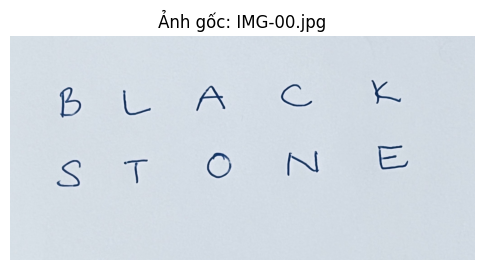

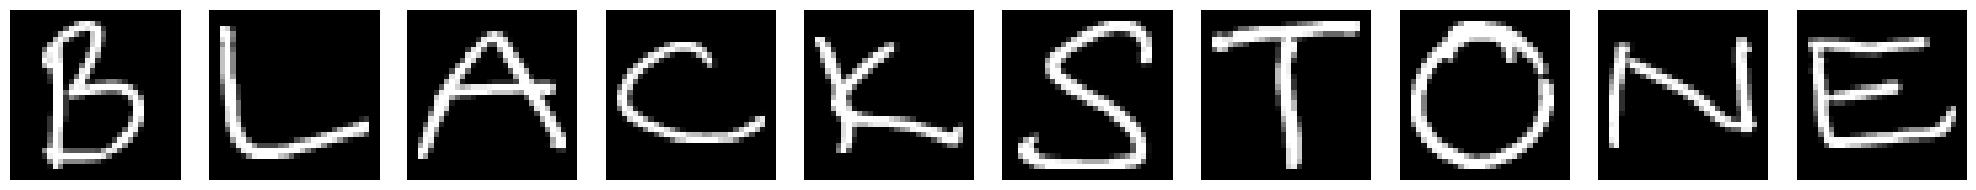

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step
Dự đoán ký tự: BLACKSTONE
Processing IMG-01.jpg...


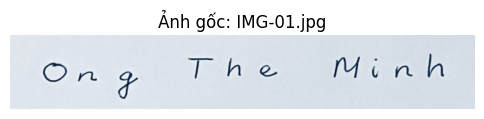

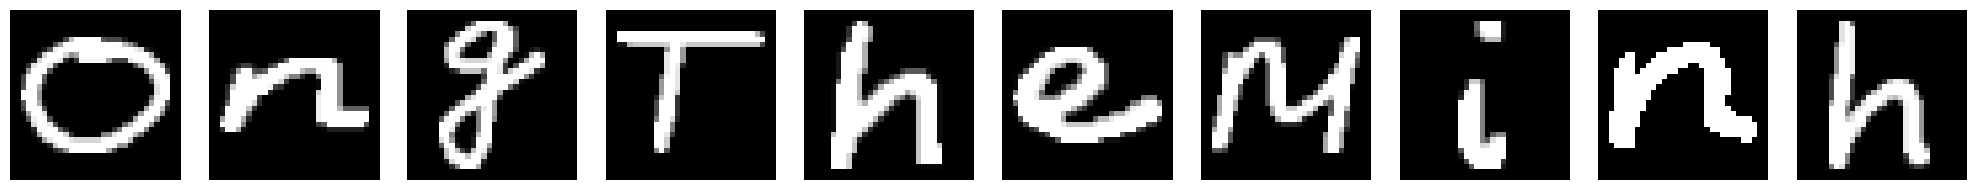

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
Dự đoán ký tự: OngTheMINh
Processing IMG-02.jpg...


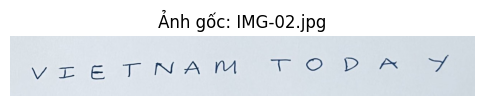

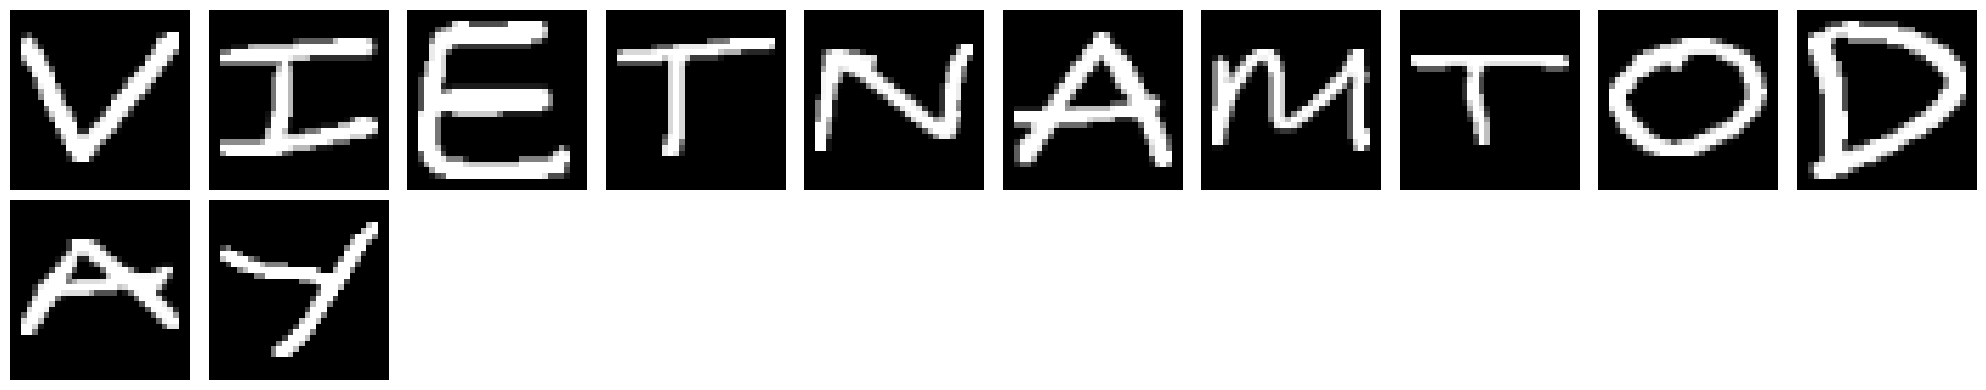

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
Dự đoán ký tự: VIETNAMTODAY
Processing IMG-03.jpg...


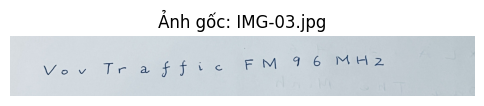

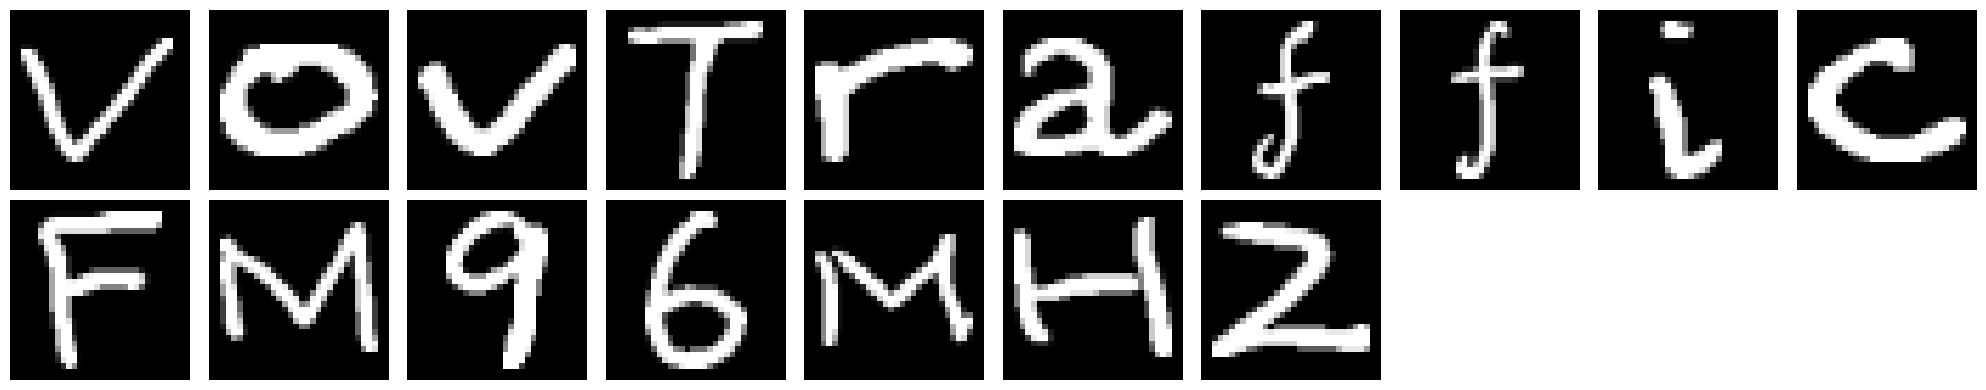

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
Dự đoán ký tự: VOVTraFFICFM96MHZ
Processing IMG-04.jpg...


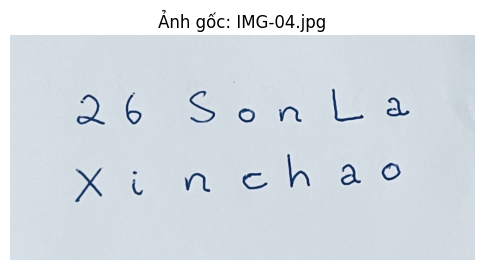

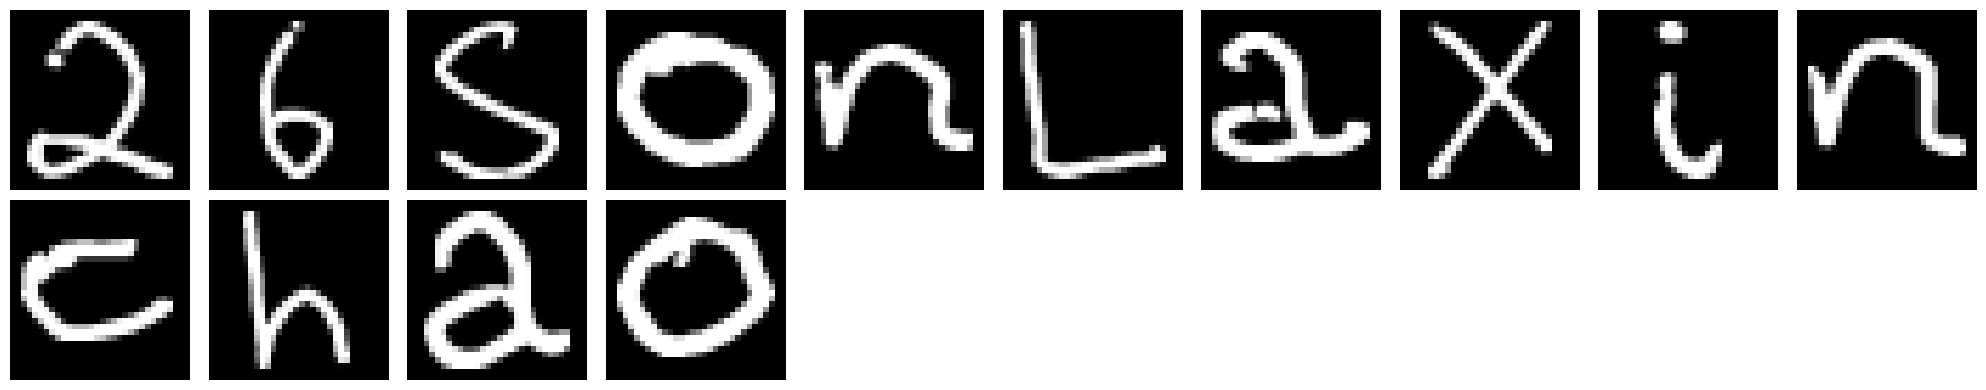

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
Dự đoán ký tự: 26SOnLaXInChaO
Processing IMG-05.jpg...


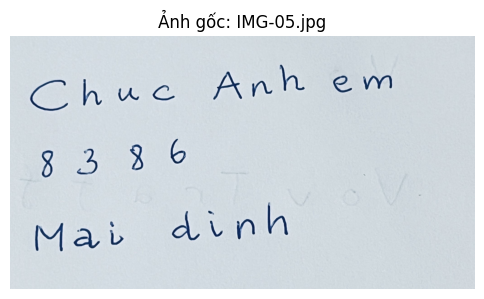

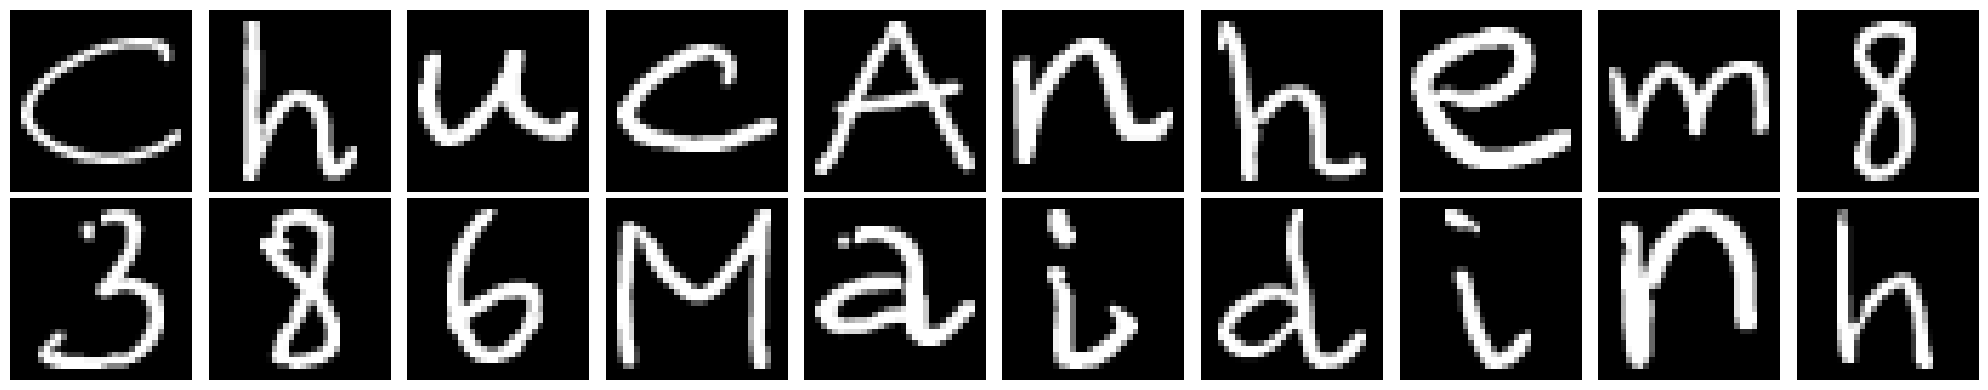

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
Dự đoán ký tự: ChUCAnheM8386MaIdINh
Processing IMG-06.jpg...


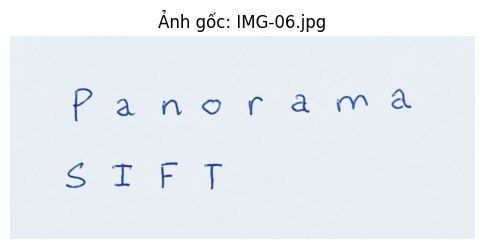

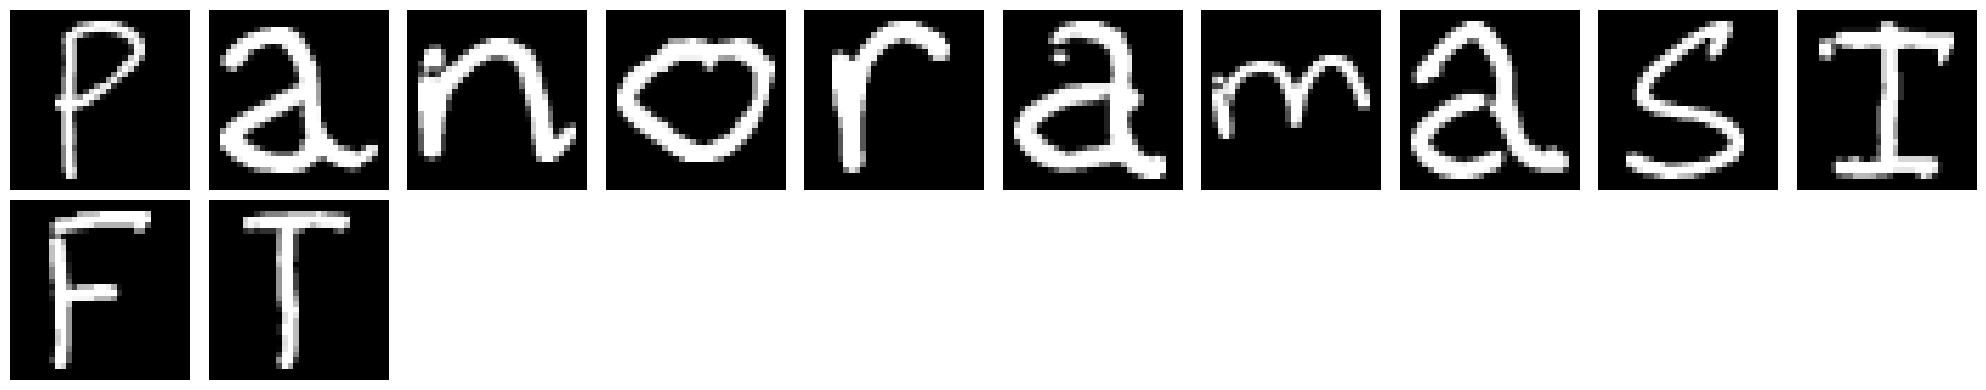

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
Dự đoán ký tự: PaNOraMaSIFT
Processing IMG-07.jpg...


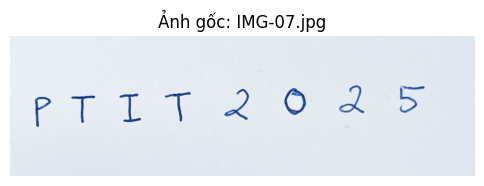

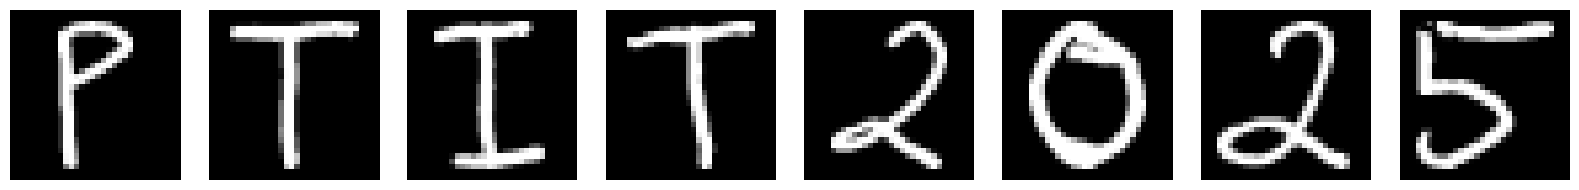

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step
Dự đoán ký tự: PTIT2O25
Processing Screenshot 2025-11-17 122107.png...


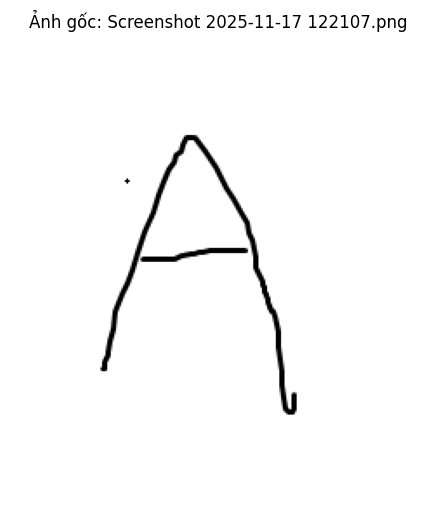

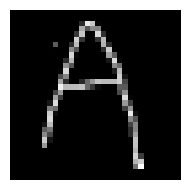

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
Dự đoán ký tự: A
Processing Screenshot 2025-11-17 122149.png...


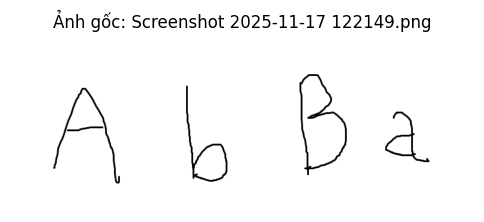

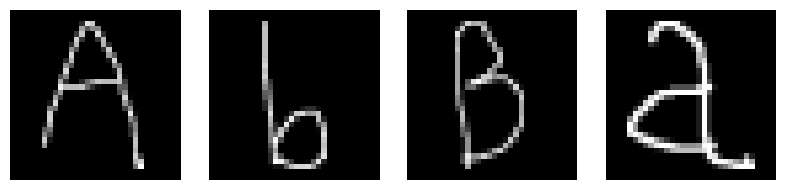

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step
Dự đoán ký tự: AbBd
Processing Screenshot 2025-11-17 204444.png...


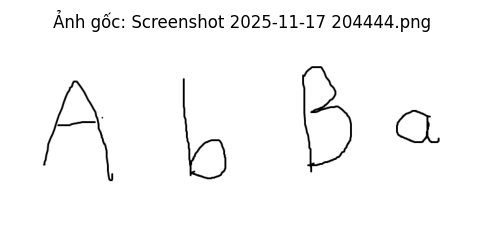

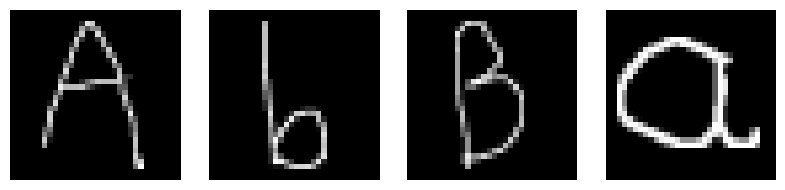

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
Dự đoán ký tự: AbBa
Hoàn tất xử lý tất cả ảnh trong thư mục.


In [15]:
import os
import cv2
import matplotlib.pyplot as plt

folder_path = "img"
all_chars = []

for filename in os.listdir(folder_path):
    if filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp")):
        print(f"Processing {filename}...")

        image_path = os.path.join(folder_path, filename)
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(6,6))
        plt.title(f"Ảnh gốc: {filename}")
        plt.imshow(img_rgb)
        plt.axis("off")
        plt.show()
        
        process_and_show(image_path)

print("Hoàn tất xử lý tất cả ảnh trong thư mục.")
